<a href="https://colab.research.google.com/github/nyp-sit/it3103/blob/main/week13/token_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical 4b - Token Classification

In this practical we will learn how to use the HuggingFace Transformers library to perform token classification.

Just like what we did in Practical 3a, we will use the DistiBERT transformer architecture, which also allows us to classify each and every word in a sentence.

####**NOTE: Be sure to set your runtime to a GPU instance!**

## Section 1 - Install Transformers

Run the following cell to install the HuggingFace Transformers library.

In [1]:
!pip install transformers

     |████████████████████████████████| 2.3MB 7.4MB/s 
     |████████████████████████████████| 901kB 49.3MB/s 
     |████████████████████████████████| 3.3MB 48.6MB/s 


## Section 2 - Import, Define Classes and Helper Functions

Run the following cell to import all necessary libraries, define the necessary variables, classes and functions required for our processing.


In [8]:
import pandas as pd
import numpy as np
import torch
from transformers import DistilBertTokenizerFast
from transformers import AutoTokenizer

# Initialize the DistilBERT tokenizer.
#
#tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
# Define a function that loads up a space-, comma-, tab-separated file
# and extracts the input word and label for each word.
# 
# It is assumed that the file is in the CONLL format:
#
#      sentence1-word1, ..., label1-1
#      sentence1-word2, ..., label1-2
#      sentence1-word3, ..., label1-3
#      <empty line>
#      sentence2-word1, ..., label2-1
#      sentence2-word2, ..., label2-2
#      ...
#      sentence2-wordn, ..., label2-n
#      <empty line>
#      ...
#
# This function returns a 2D list of words and a 2D list of labels
# corresponding to each word.
#
def load_conll(filepath, delimiter=' ', word_column_index=0, label_column_index=3):
    all_texts = []
    all_tags = []

    texts = []
    tags = []

    # Opens the file.
    #
    with open(filepath, "r") as f:

        # Loops through each line 
        for line in f:

            # Split each line by its delimiter (default is a space)
            tokens = line.split(delimiter)

            # If the line is empty, treat it as the end of the
            # previous sentence, and construct a new sentence
            #
            if len(tokens) == 1:
                # Append the sentence
                # 
                all_texts.append(texts)
                all_tags.append(tags)

                # Create a new sentence
                #
                texts = []
                tags = []
            else:
                # Not yet end of the sentence, continue to add
                # words into the current sentence
                #
                thistext = tokens[word_column_index].replace('\n', '')
                thistag = tokens[label_column_index].replace('\n', '')

                texts.append(thistext)
                tags.append(thistag)

    # Insert the last sentence if it contains at least 1 word.
    #
    if len(texts) > 0:
        all_texts.append(texts)
        all_tags.append(tags)

    # Return the result to the caller
    #
    return all_texts, all_tags


# This function is taken from HuggingFace's documentation at:
# https://huggingface.co/transformers/custom_datasets.html
#
# This function simply converts the string classification tags for each
# word into their index using the token_labels_id_by_label dictionary.
#
# Also, it uses the offset_mapping to determine which words are [CLS],
# [SEP] and sub-words so that we can leave the tag as a -100 value 
# (ignored).
# 
def encode_tags(tags, encodings):
    labels = [[token_labels_id_by_label[tag] for tag in doc] for doc in tags]
    encoded_labels = []
    for doc_labels, doc_offset in zip(labels, encodings.offset_mapping):
        # create an empty array of -100
        doc_enc_labels = np.ones(len(doc_offset),dtype=int) * -100
        arr_offset = np.array(doc_offset)

        # set labels whose first offset position is 0 and the second is not 0
        doc_enc_labels[(arr_offset[:,0] == 0) & (arr_offset[:,1] != 0)] = doc_labels
        encoded_labels.append(doc_enc_labels.tolist())

    return encoded_labels

# This class is used to send data into the model for training
#
class TokenClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    # This function is called during the model training to feed data
    # for the training.
    #
    # It returns a single data sample with the following dictionary:
    # {
    #    "input_ids":       tensor([  101,  7327, 19164,  2446,  2655,  2000, 17757,  2329, 12559,  1012,   102,     0,     0, ...]),
    #    "attention_mask":  tensor([    1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     0,     0, ...]),
    #    "labels":          tensor([ -100,     3,     0,     7,     0,     0,     0,     7,     0,     0,  -100,  -100,  -100, ...]),
    # }
    #
    def __getitem__(self, idx):
        # Retrieves
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    # Returns the number of samples in this dataset.
    #
    def __len__(self):
        return len(self.labels)




## Section 3 - Defining Our Classification Labels

Run the following cell to declare the token classification labels that we will be using.
 

In [9]:

# Define a list of unique token labels that we will recognize
#
token_labels = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

# Create a reverse-mapping dictionary of the label -> index.
#
token_labels_id_by_label = {tag: id for id, tag in enumerate(token_labels)}



## Section 4 - Load and Split Our Data

We are now prepared to process our data. 

Go ahead and upload the token_train.txt, token_test.txt file into Colab.

Then, fill up the codes below to load the data from the token_train.txt, token_test.txt file.
   ```
   train_texts, train_tags = load_conll("token_train.txt")
   val_texts, val_tags = load_conll("token_test.txt")
   ```



In [10]:
# TODO:
# Loads the training and test text files.
#...#

train_texts, train_tags = load_conll("token_train.txt")
val_texts, val_tags = load_conll("token_test.txt")


print (train_texts[0:5])
print (train_tags[0:5])
print (len(train_texts))
print (len(val_texts))


[['-DOCSTART-'], ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], ['Peter', 'Blackburn'], ['BRUSSELS', '1996-08-22'], ['The', 'European', 'Commission', 'said', 'on', 'Thursday', 'it', 'disagreed', 'with', 'German', 'advice', 'to', 'consumers', 'to', 'shun', 'British', 'lamb', 'until', 'scientists', 'determine', 'whether', 'mad', 'cow', 'disease', 'can', 'be', 'transmitted', 'to', 'sheep', '.']]
[['O'], ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O'], ['B-PER', 'I-PER'], ['B-LOC', 'O'], ['O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]
14987
3684


## Section 5 - Preparing Our Data for Training

Modify the following cell to:

1. Tokenize all the training and validation input texts into individual word indexes and attention masks.
   ```
   train_encodings = tokenizer(train_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)
val_encodings = tokenizer(val_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)
   ```

2. Convert the individual word tags into their corresponding indexes. 
   ```
   train_labels = encode_tags(train_tags, train_encodings)
val_labels = encode_tags(val_tags, val_encodings)
   ```

3. Remove the 'offset_mapping' since we do not require that for training.
   ```
   train_encodings.pop("offset_mapping") # we don't want to pass this to the model
val_encodings.pop("offset_mapping")
   ```

3. Construct the TokenClassificationDataset in preparation for training.
   ```
   train_dataset = TokenClassificationDataset(train_encodings, train_labels)
val_dataset = TokenClassificationDataset(val_encodings, val_labels)
   ```

In [11]:
# TODO:
# Call the tokenizer to assign word indexes to each word.
#
# NOTE: When loading up the data from the train.txt and test.txt (CONLL format),
# the words have already been split up. 
#...#
train_encodings = tokenizer(train_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)
val_encodings = tokenizer(val_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)


# TODO:
# Call the encode_tags function to convert the string-based tag per word
# into numeric indexes.
#...#
train_labels = encode_tags(train_tags, train_encodings)
val_labels = encode_tags(val_tags, val_encodings)



# TODO:
# Remove the offset_mapping list as we don't need it for training.
#...#

train_encodings.pop("offset_mapping") # we don't want to pass this to the model
val_encodings.pop("offset_mapping")


# TODO:
# Construct the data set to be used for training.
#...#





In [30]:
len(train_encodings['input_ids'])

14987

In [31]:
import tensorflow as tf

# train_dataset = TokenClassificationDataset(train_encodings, train_labels)
# val_dataset = TokenClassificationDataset(val_encodings, val_labels)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

Run the following cell below to see the train_texts and individual samples in the dataset for the first few lines of text.

In [37]:
print (len(train_texts))
print (len(val_texts))

iterator = iter(train_dataset)
for i in range(3):
    print (train_texts[i])
    #print (train_dataset.__getitem__(i))
    print(iterator.get_next())
    print ("---")
    


14987
3684
['-DOCSTART-']
({'input_ids': <tf.Tensor: shape=(164,), dtype=int32, numpy=
array([  101,  1011,  9986, 14117,  2102,  1011,   102,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
   

## Section 6 - Train our Token Classification Model

Run the following cell below to train the token classification model.

Now, this training per epoch will take up a while complete. If it takes too long, ensure that you updated your runtime to use a GPU instance. If it still takes too long, we'll leave it running for 5 minutes, and use a saved model that I've already trained with this same dataset.


In [42]:
from transformers import (
    TFAutoModelForTokenClassification, 
    TFTrainer, 
    TFTrainingArguments
)

training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy = 'epoch'
)
with training_args.strategy.scope():
    token_model = TFAutoModelForTokenClassification.from_pretrained('distilbert-base-uncased', num_labels=len(token_labels))

trainer = TFTrainer(
    model=token_model,                   # the instantiated Token Classification 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForTokenClassification: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferenc

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: Using `-1` to mask the loss for the token is deprecated. Please use `-100` instead.
  return py_builtins.overload_of(f)(*args)


In [44]:
preds = trainer.predict(val_dataset)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: Using `-1` to mask the loss for the token is deprecated. Please use `-100` instead.
  return py_builtins.overload_of(f)(*args)


## Section 7 - Save our Token Classification Model

Once your training is complete, save the model and download it to your own computer before the session expires!

Alternatively, you can connect to and push your model to Google Drive once your training has completed.

In [46]:
preds = trainer.predict(val_dataset)

In [53]:
len(preds[2])

1

In [43]:
token_model.save_pretrained('tokenclassification_model')

## Section 8 - Evaluate the Model

Run the following cells below to evaluate your model performance.

Obviously, you can only do this AFTER your training is completed. 

In [56]:
import numpy as np

from transformers import AutoTokenizer

# Initialize the DistilBERT tokenizer.
#
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Define a list of unique labels that we will recognized
#
token_labels = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

# Define the function to infer the individual tokens
#
def infer_tokens(text):
    encodings = tokenizer([text], is_split_into_words=True, padding=True, truncation=True, return_offsets_mapping=True, return_tensors="tf")

    label_mapping = [0] * len(encodings.offset_mapping[0])
    for i, offset in enumerate(encodings.offset_mapping[0]):
        if encodings.offset_mapping[0][i][0] == 0 and encodings.offset_mapping[0][i][1] != 0:
            label_mapping[i] = 1

    encodings.pop("offset_mapping")
    #encodings = encodings.to("cuda")

    # Use the token classification model to predict the labels
    # for each word.
    #
    output = token_model(encodings)[0]

    result = []

    for i in range(output.shape[1]):
        if label_mapping[i] == 1:
            result.append(np.argmax(output[0][i]).item())

    return result



In [57]:
from tqdm import tqdm

# This function takes in a list of sentences (texts) and passes them into the
# infer_tokens method to tokenize and predict each word's label.
# 
# It will then convert the list of labels into their numeric index, and
# return both actual label and predicted label to the caller.
#
def get_actual_pred_y(texts, labels):
    all_actual_y = []
    all_pred_y = []

    for i in tqdm(range(len(texts))):
        x = texts[i]

        actual_y = list(filter(lambda x: x != -100, labels[i]))
        pred_y = infer_tokens(x)

        if (len(actual_y) == len(pred_y)):
            all_actual_y += actual_y
            all_pred_y += pred_y
        else:
            print ("Error: %d, %d, %d, %s " % (i, len(actual_y), len(pred_y), x ))

    return all_actual_y, all_pred_y

# Get the actual and predicted labels for all words in all sentences
# for both the training and the test set.
# 
actual_y_train, pred_y_train = get_actual_pred_y(train_texts, train_labels)
actual_y_test, pred_y_test = get_actual_pred_y(val_texts, val_labels)



100%|██████████| 3684/3684 [05:22<00:00, 11.41it/s]


(9, 9)


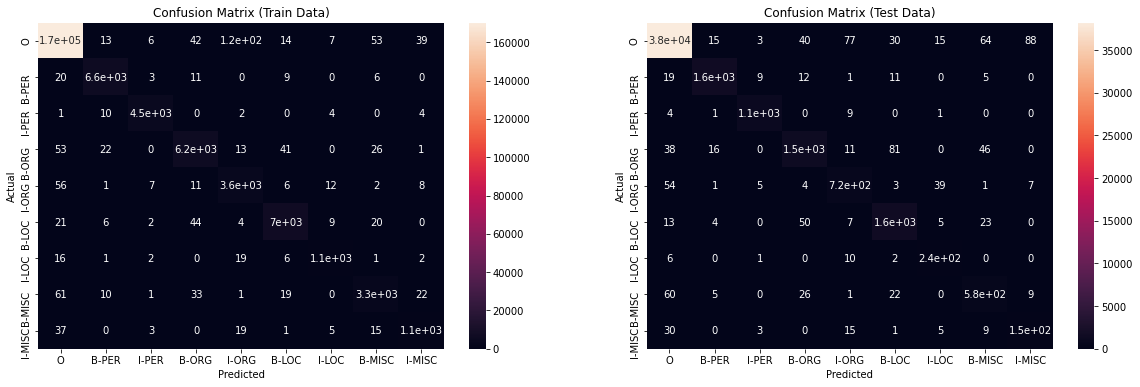

Train Data
--------------------------------------------------------
              precision    recall  f1-score   support

           O       1.00      1.00      1.00    170524
       B-PER       0.99      0.99      0.99      6600
       I-PER       0.99      1.00      1.00      4528
       B-ORG       0.98      0.98      0.98      6321
       I-ORG       0.95      0.97      0.96      3704
       B-LOC       0.99      0.99      0.99      7140
       I-LOC       0.97      0.96      0.96      1157
      B-MISC       0.96      0.96      0.96      3438
      I-MISC       0.93      0.93      0.93      1155

    accuracy                           1.00    204567
   macro avg       0.97      0.97      0.97    204567
weighted avg       1.00      1.00      1.00    204567


Test Data
--------------------------------------------------------
              precision    recall  f1-score   support

           O       0.99      0.99      0.99     38554
       B-PER       0.97      0.96      0.97      1

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def display_model_evaluation_results(y_train, pred_y_train, y_test, pred_y_test, labels):
    
    plt.figure(figsize=(20,6))  

    labels = np.array(labels)

    # Print the first Confusion Matrix for the training data
    #
    cm = confusion_matrix(y_train, pred_y_train)
    print (cm.shape)

    cm_df = pd.DataFrame(cm, labels, labels)
    plt.subplot(1, 2, 1)
    plt.title('Confusion Matrix (Train Data)')
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')        
    
    # Print the second Confusion Matrix for the test data
    #    
    cm = confusion_matrix(y_test, pred_y_test)
    
    cm_df = pd.DataFrame(cm, labels, labels)          
    plt.subplot(1, 2, 2)
    plt.title('Confusion Matrix (Test Data)')
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')        
    
    plt.show()

    # Finally display the classification reports
    #
    print ("Train Data")
    print ("--------------------------------------------------------")
    print(classification_report(y_train, pred_y_train, target_names=labels))
    print ("")
    print ("Test Data")
    print ("--------------------------------------------------------")
    print(classification_report(y_test, pred_y_test, target_names=labels))


display_model_evaluation_results(actual_y_train, pred_y_train, actual_y_test, pred_y_test, token_labels)